## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0268
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.9788e-04
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.4587e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.1804e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4.9397e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 4.6779e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 4.4462e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.3496e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.2769e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 4.1683e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 4.0340e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 3.9001e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 3.7762e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 3.6646e-04
Epoch

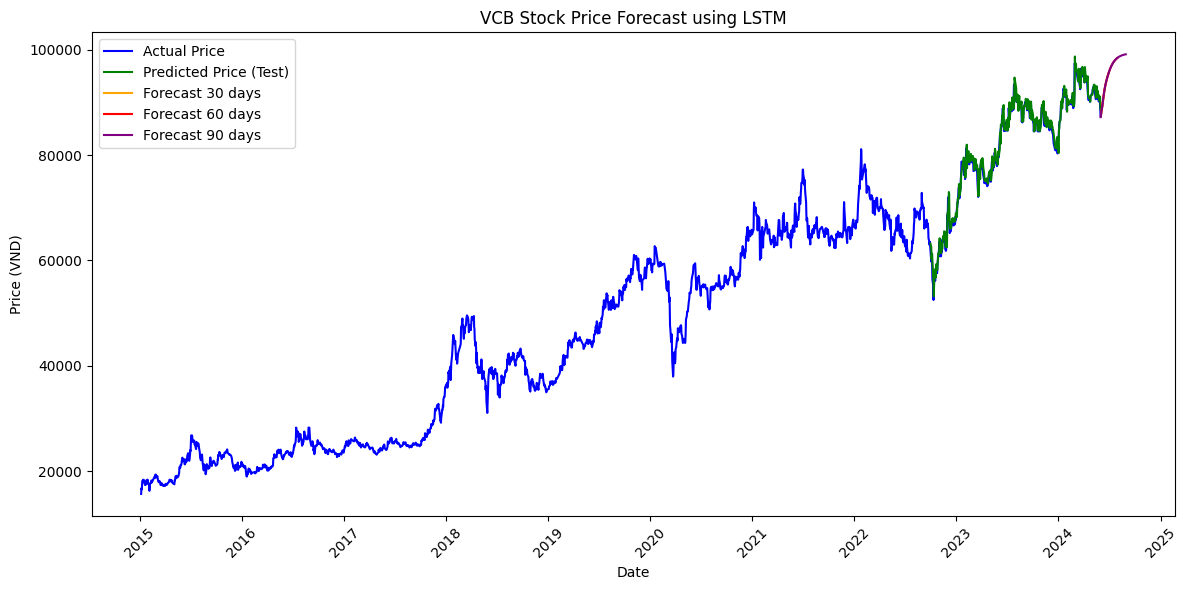

In [2]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')  # Plot all data

# Vẽ giá dự đoán trên tập kiểm tra (chỉ trong khoảng thời gian của tập kiểm tra)
test_data_start = df.index[train_size + n_lookback] 
test_data_end = df.index[-1]  
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback],
         Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Start from the day after the last data point
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('VCB Stock Price Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


In [3]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  87362.085938
2024-06-02  87887.632812
2024-06-03  88315.593750
2024-06-04  88600.679688
2024-06-05  88876.000000
...                  ...
2024-08-25  99077.679688
2024-08-26  99090.039062
2024-08-27  99101.843750
2024-08-28  99113.078125
2024-08-29  99123.773438

[90 rows x 1 columns]


In [4]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1270.909161473485
MAPE: 1.213270502716568 %
MDA: 959.1897977941182


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



Epoch 1/100


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0486
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0015
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0014
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0013
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0012
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0012
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0011
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0011
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0010
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.9907e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.5530e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.1401e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 8.7523e-04
Epoch 15/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step 

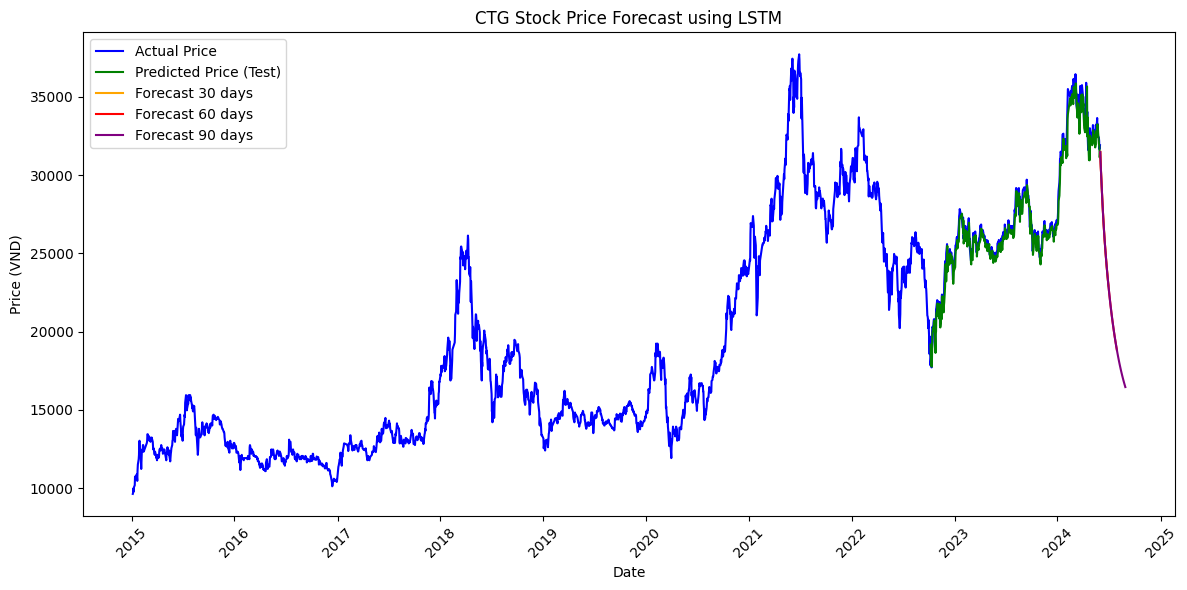

In [6]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')  # Plot all data

# Vẽ giá dự đoán trên tập kiểm tra (chỉ trong khoảng thời gian của tập kiểm tra)
test_data_start = df.index[train_size + n_lookback] 
test_data_end = df.index[-1]  
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback],
         Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Start from the day after the last data point
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('CTG Stock Price Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu CTG trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu CTG trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  31481.371094
2024-06-02  30947.378906
2024-06-03  30479.158203
2024-06-04  30084.203125
2024-06-05  29691.583984
...                  ...
2024-08-25  16710.990234
2024-08-26  16647.445312
2024-08-27  16585.039062
2024-08-28  16523.751953
2024-08-29  16463.566406

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 647.2700630466874
MAPE: 1.8146659242147625 %
MDA: 496.437538202934


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20)
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Dự đoán tương lai 30, 60, 90 ngày
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  # Dự đoán 90 ngày
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0264
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0011
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.2449e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 8.4527e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.9102e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7.1477e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 6.5555e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.1169e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.7451e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.4213e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.1376e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 4.8857e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.6566e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 4.4434e-04
Epoch 15/

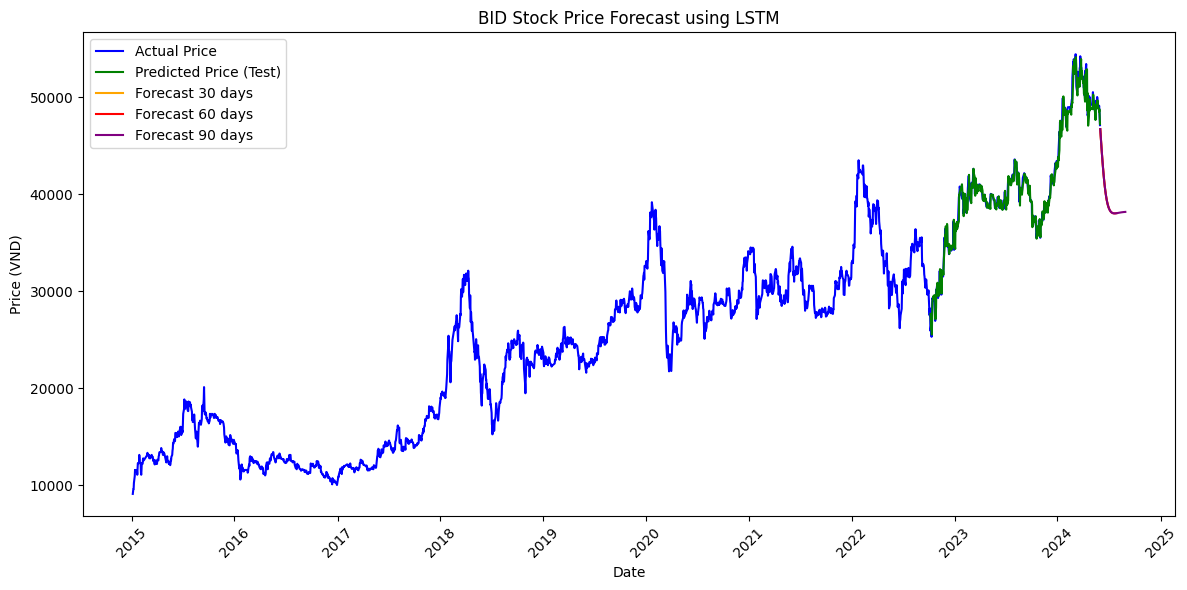

In [10]:
# Trực quan hóa
plt.figure(figsize=(12, 6))

# Vẽ giá thực tế
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')  # Plot all data

# Vẽ giá dự đoán trên tập kiểm tra (chỉ trong khoảng thời gian của tập kiểm tra)
test_data_start = df.index[train_size + n_lookback] 
test_data_end = df.index[-1]  
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback],
         Y_pred_test, label='Predicted Price (Test)', color='green')

# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Start from the day after the last data point
plt.plot(future_dates[:30], future_predictions[:30], label='Forecast 30 days', color='orange')
plt.plot(future_dates[:60], future_predictions[:60], label='Forecast 60 days', color='red')
plt.plot(future_dates, future_predictions, label='Forecast 90 days', color='purple')

plt.title('BID Stock Price Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


In [11]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu BID trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu BID trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  46696.421875
2024-06-02  46267.976562
2024-06-03  45815.750000
2024-06-04  45373.359375
2024-06-05  44945.667969
...                  ...
2024-08-25  38151.562500
2024-08-26  38154.238281
2024-08-27  38156.757812
2024-08-28  38159.140625
2024-08-29  38161.375000

[90 rows x 1 columns]


In [12]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 834.3062194327395
MAPE: 1.490887063022002 %
MDA: 598.271350664731
